# 1. Load Data
------

In [2]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels

In [22]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [23]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [24]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Time Series Decomposition

------------------------

### **Time Series Decomposition — Theory**

**Time series decomposition** is a technique used to separate a series into smaller, interpretable parts. This helps understand how data behavior is formed over time.

The series is divided into three main components:

---

#### 🔹 **1. Trend**

Represents the **long-term movement** of the series.
E.g.: gradual temperature increase during the day.

---

#### 🔹 **2. Seasonality (Seasonal)**

**Repetitive and predictable** patterns, such as daily, weekly, or annual cycles.
In the project, we use a **24-hour daily cycle**.

---

#### 🔹 **3. Residual**

It's what remains after removing trend and seasonality.
Represents **noise**, random fluctuations, or unexpected events.

---

#### **Function used: `seasonal_decompose`**

The function automatically separates the series into these three components.

#### **Main parameters used:**

#### ✔ `serie`

The time series with temperature values, indexed by time.

#### ✔ `model='additive'`

Uses the model:
```
series = trend + seasonality + residual
```

Indicated when the amplitude of cycles is constant.

#### ✔ `period=period`

Defines **the size of the seasonal cycle**.
In the project: `2880` points (one full day, measuring every 30 s).

#### ✔ `extrapolate_trend='freq'`

Avoids gaps in the trend by filling values at the edges.

---

### 📤 **Main model outputs**

The decomposition returns:

* **`decomposition.observed`** → the original series
* **`decomposition.trend`** → long-term trend
* **`decomposition.seasonal`** → daily repetitive pattern
* **`decomposition.resid`** → noise after removing the other components

These elements allow visualizing, analyzing, and understanding **how each part contributes to the time series behavior**.

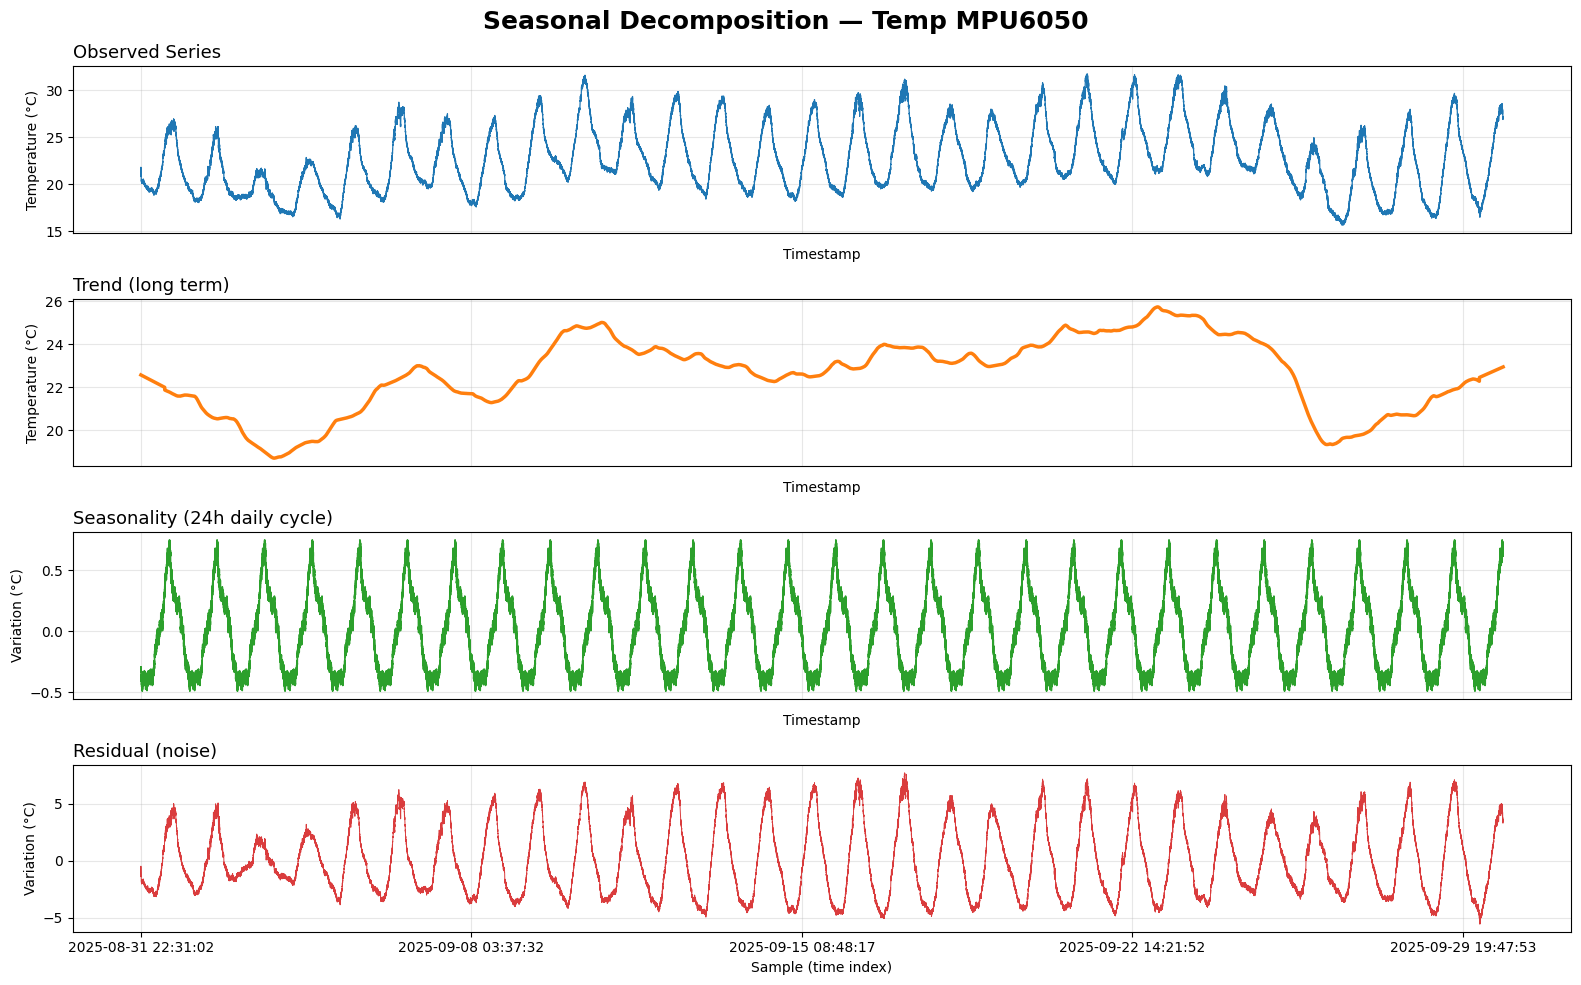

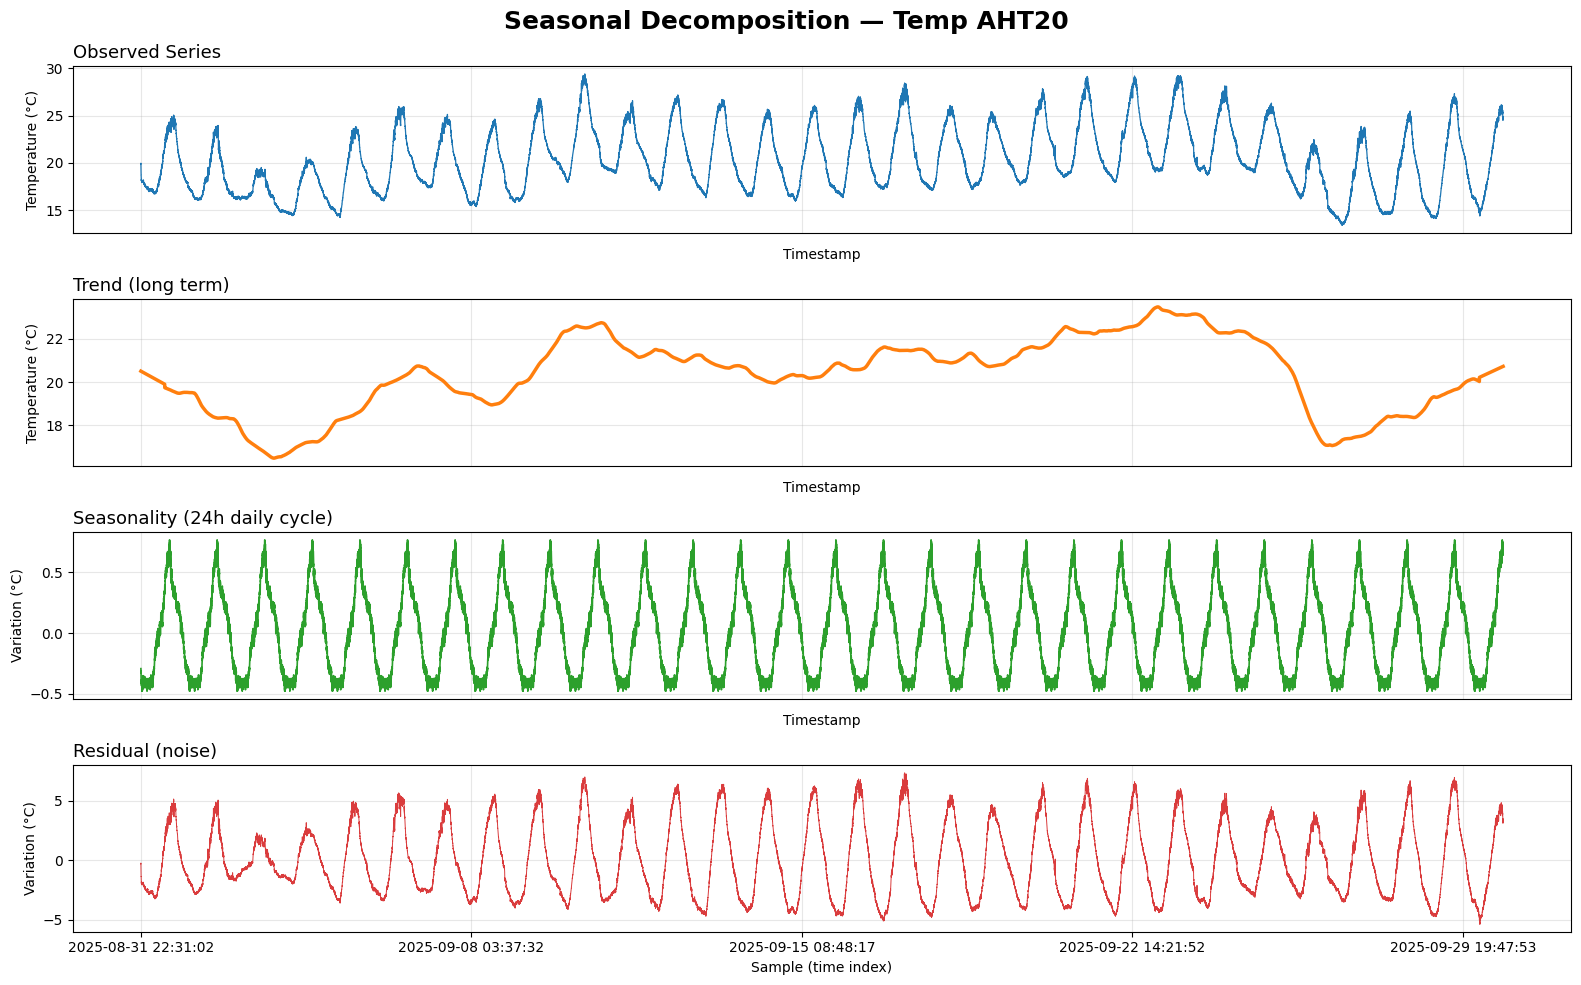

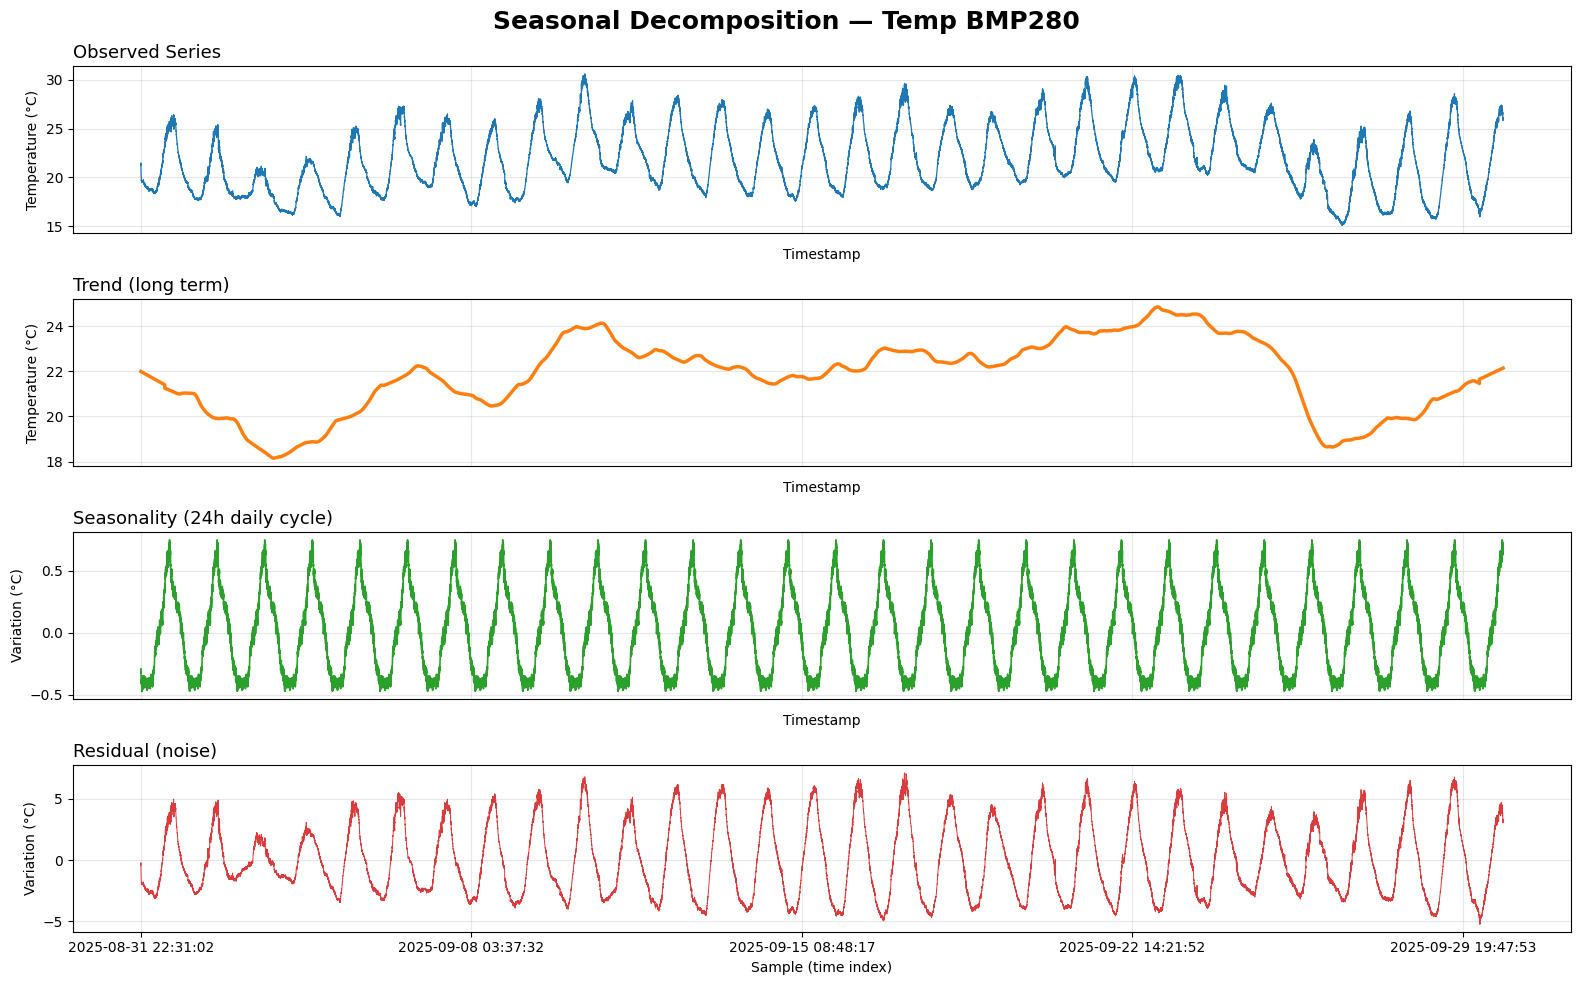

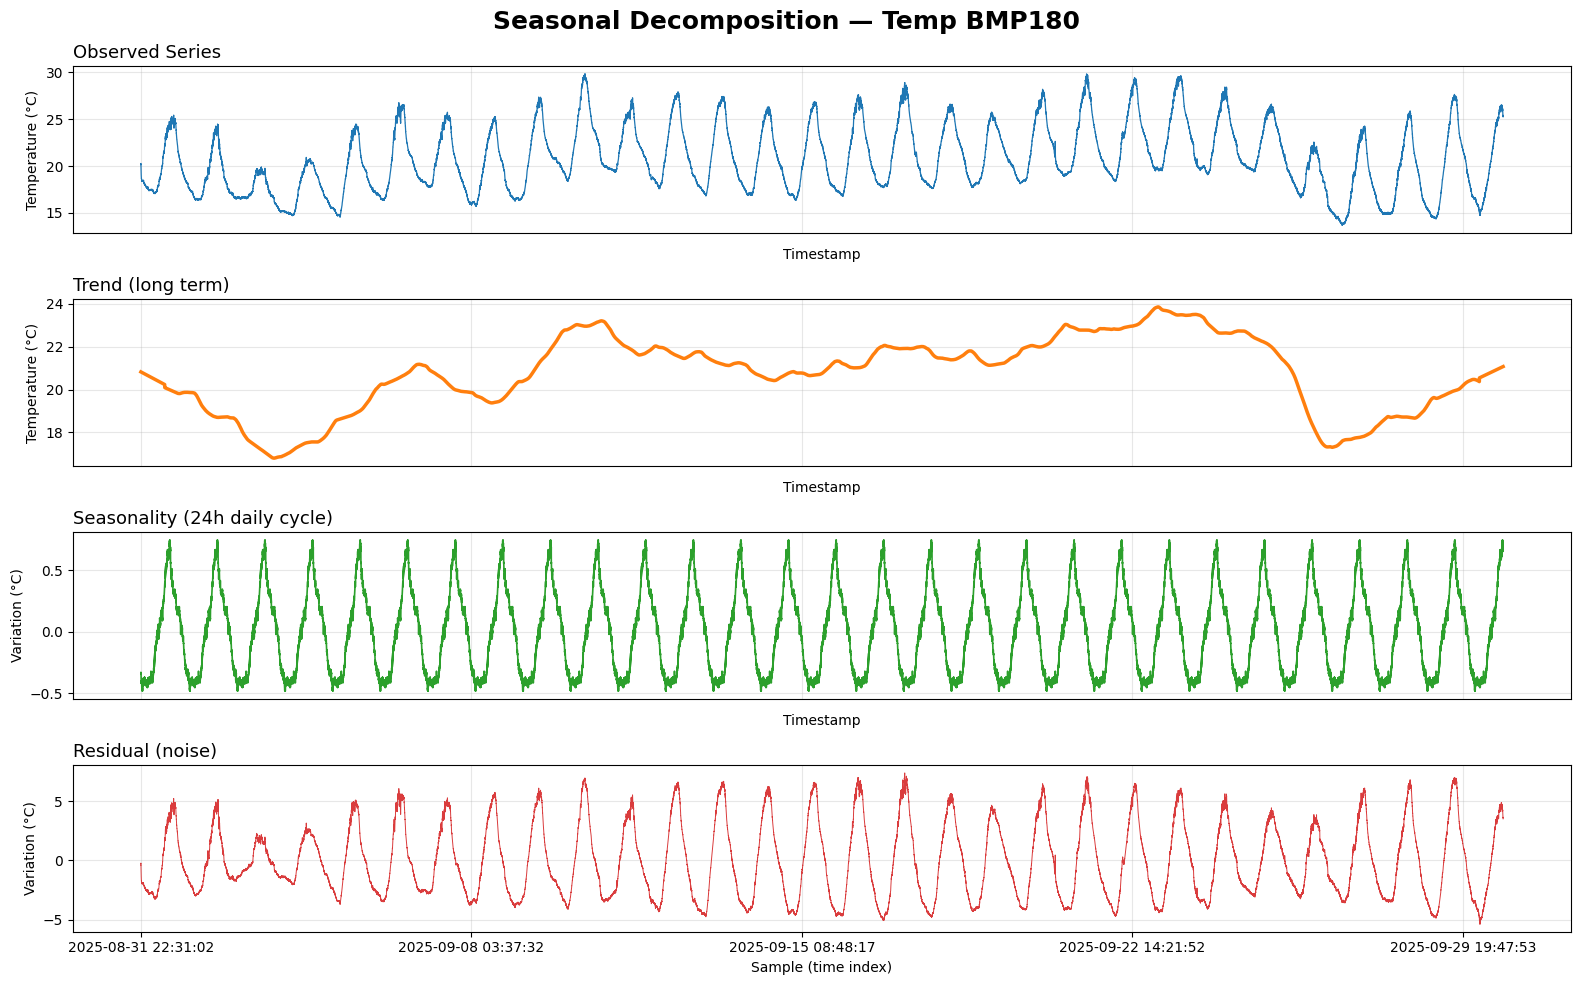

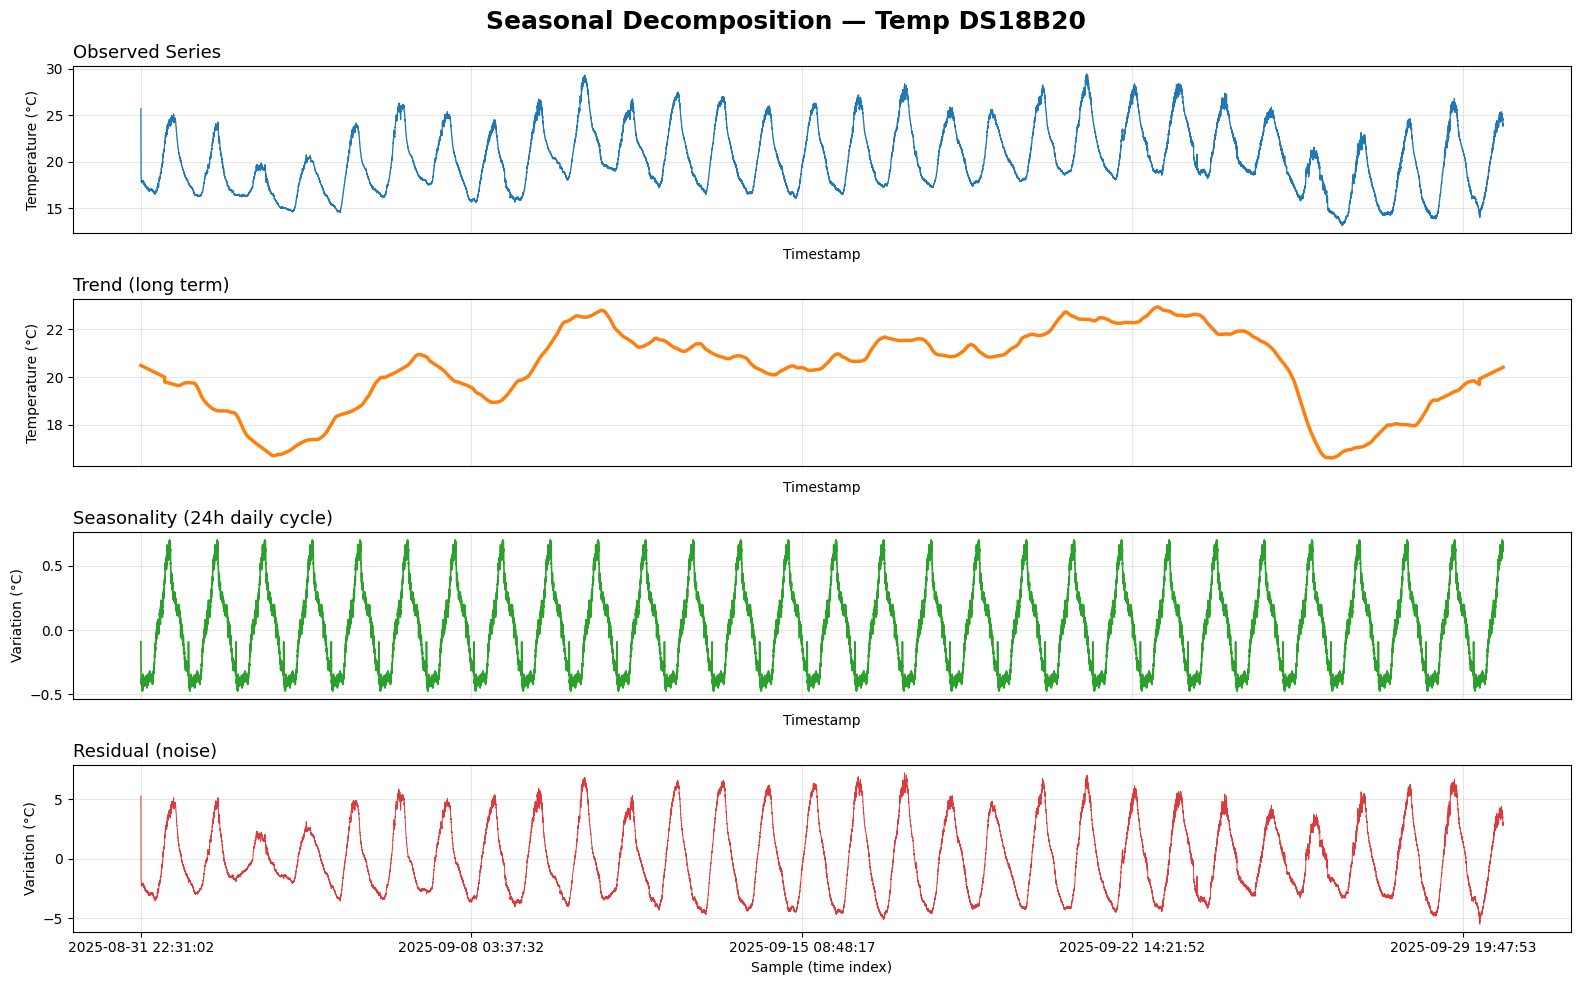

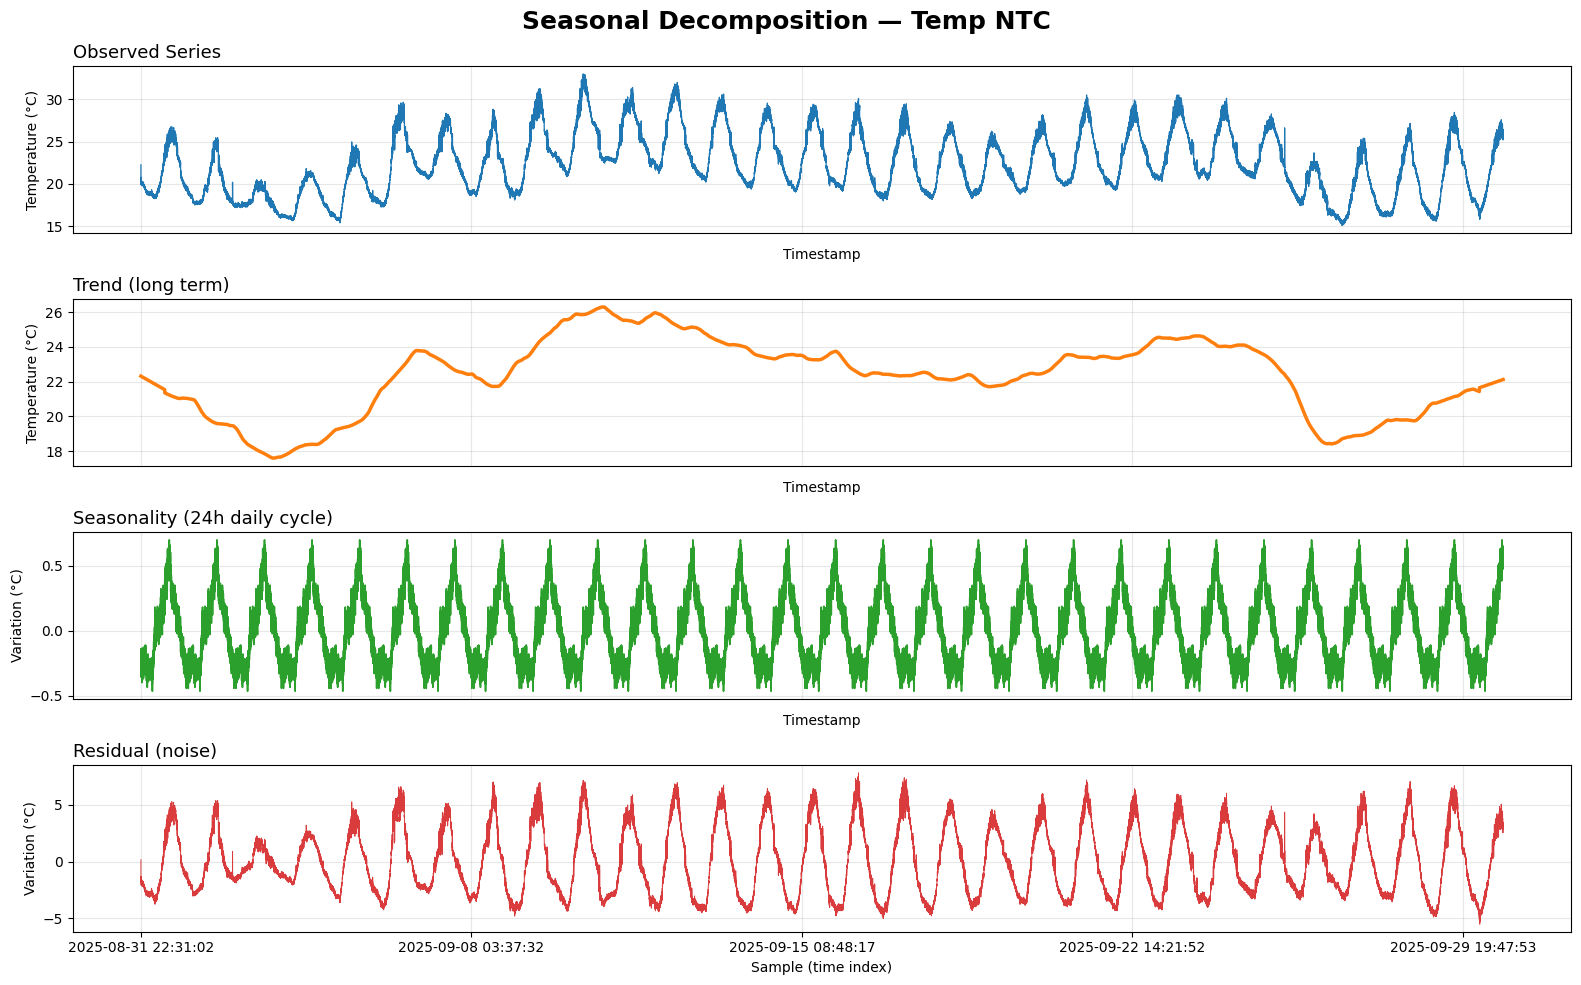

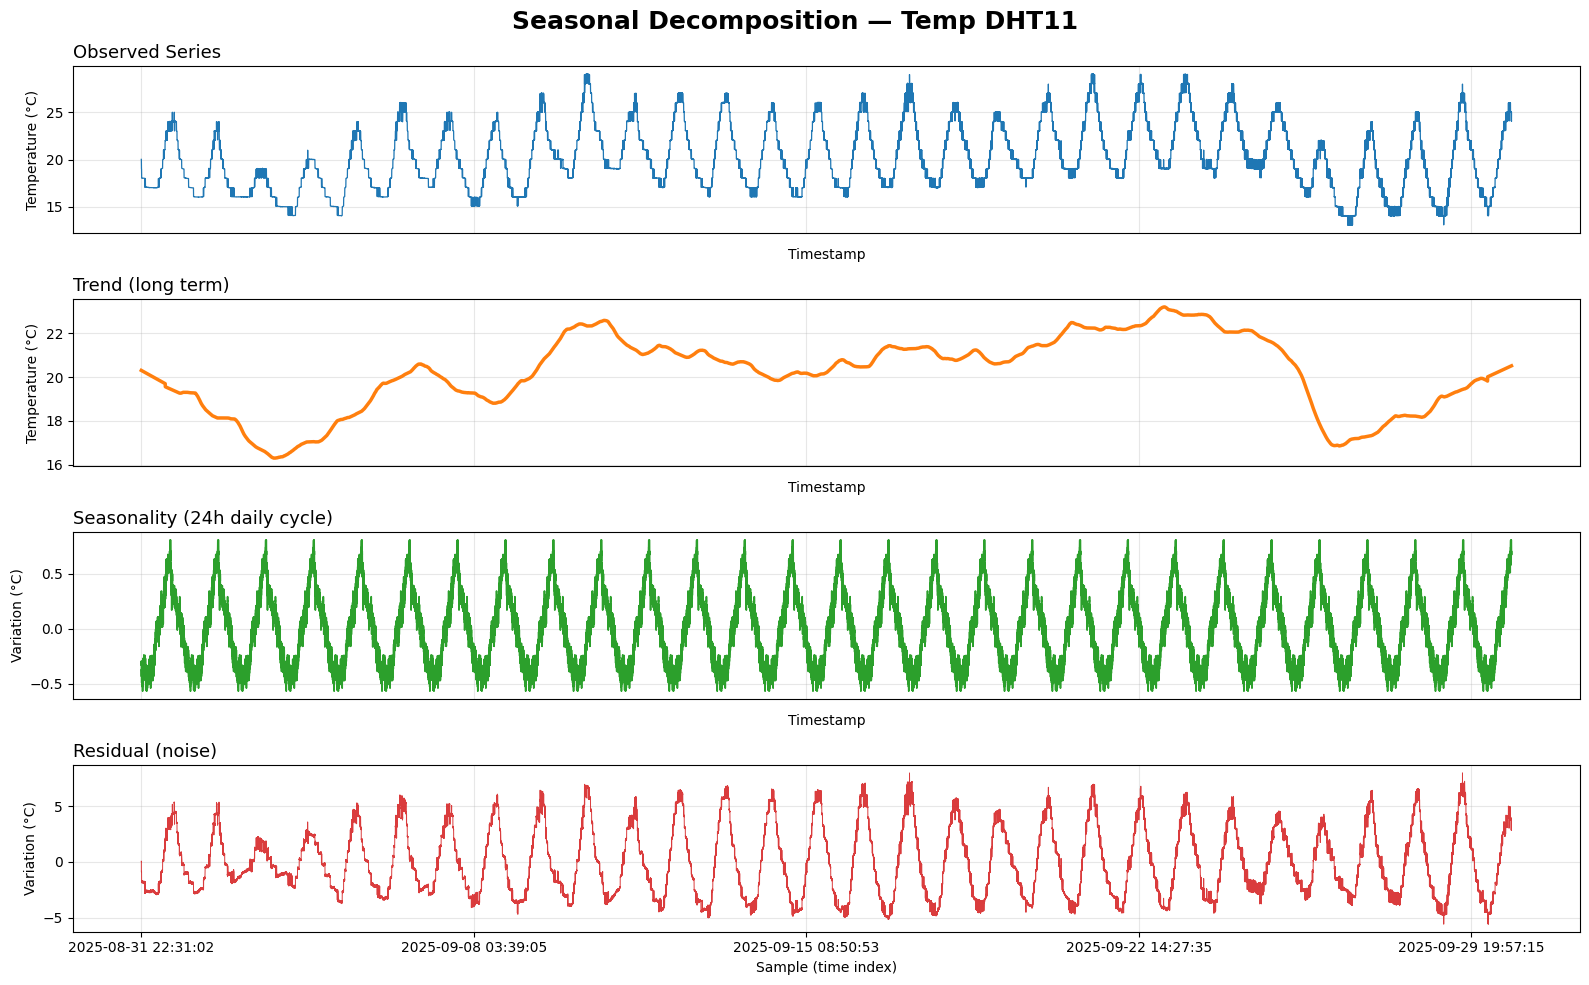

In [48]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

period = 24 * 60 * 2  #2880 points per day, considering measurements every 30 seconds
temp_cols = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
             'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors

for col in temp_cols: #for all temperature sensors
    serie = df[[col, 'Timestamp']].dropna().set_index('Timestamp')[col] #Clean series without error data
    decomposition = seasonal_decompose(# Seasonal decomposition, decomposes a time series into:
                                       # trend, seasonality and residual
        serie,
        model='additive', #series = trend + seasonality + residual (additive model)
        period=period,#the period in which data repeats, in this case we consider daily cycle
        extrapolate_trend='freq' #avoids NaNs at the edges
    )

    #Creates the 4 graphs for each SENSOR
    fig, axes = plt.subplots(4, 1, figsize=(16, 10), dpi=100)
    fig.suptitle(f'Seasonal Decomposition — {col.replace("_C", "").replace("_", " ")}',
                 fontsize=18, fontweight='bold', y=0.98)

    #OBSERVED
    decomposition.observed.plot(ax=axes[0], color='#1f77b4', linewidth=0.9)
    axes[0].set_title('Observed Series', fontsize=13, loc='left')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticklabels([])
    axes[0].tick_params(bottom=False)

    #TREND
    decomposition.trend.plot(ax=axes[1], color='#ff7f0e', linewidth=2.5)
    axes[1].set_title('Trend (long term)', fontsize=13, loc='left')
    axes[1].set_ylabel('Temperature (°C)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticklabels([])
    axes[1].tick_params(bottom=False)

    #SEASONALITY
    decomposition.seasonal.plot(ax=axes[2], color='#2ca02c', linewidth=1.2)
    axes[2].set_title('Seasonality (24h daily cycle)', fontsize=13, loc='left')
    axes[2].set_ylabel('Variation (°C)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticklabels([])
    axes[2].tick_params(bottom=False)

    #RESIDUAL
    decomposition.resid.plot(ax=axes[3], color='#d62728', linewidth=0.7, alpha=0.9)
    axes[3].set_title('Residual (noise)', fontsize=13, loc='left')
    axes[3].set_ylabel('Variation (°C)')
    axes[3].set_xlabel('Sample (time index)')
    axes[3].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() #Opens a new window for each sensor

In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

metrics = [] #saves evaluation metrics

for col in temp_cols: #for each sensor
    if df[col].dropna().shape[0] < 2 * period:
        continue
    decomposition = seasonal_decompose(df[col].dropna(), model='additive', period=period)#temperature series for each sensor
    #decomposition values
    obs = decomposition.observed
    trend = decomposition.trend
    season = decomposition.seasonal
    resid = decomposition.resid
    #adds to the metrics vector created above
    metrics.append({
        'Sensor': col.replace('Temp_', '').replace('_C', ''),
        'Mean_°C': obs.mean(),
        'Std_°C': obs.std(),
        'Total_Amplitude': obs.max() - obs.min(),
        'Trend_Var': trend.max() - trend.min(),
        'Seasonal_Amplitude': season.max() - season.min(),
        'Residual_Std': resid.std(),
        'Residual_Max': resid.abs().max(),
        '%_Trend_Var': (trend.var() / obs.var()) * 100,
        '%_Seasonal_Var': (season.var() / obs.var()) * 100,
        '%_Residual_Var': (resid.var() / obs.var()) * 100,
    })
df_metrics = pd.DataFrame(metrics)#dataframe for metrics

#creates display table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_metrics)# Display complete table

,Sensor,Mean_°C,Std_°C,Total_Amplitude,Trend_Var,Seasonal_Amplitude,Residual_Std,Residual_Max,%_Trend_Var,%_Seasonal_Var,%_Residual_Var
0,MPU6050,22.595,3.505,16.090,7.020,1.022,3.125,7.644,24.261,0.511,79.517
1,AHT20,20.329,3.452,15.950,6.996,1.036,3.062,7.296,24.929,0.589,78.643
2,BMP280,21.803,3.351,15.470,6.695,1.015,2.981,7.084,24.457,0.606,79.151
3,BMP180,20.729,3.544,16.140,7.062,1.004,3.145,7.336,24.812,0.553,78.731
4,DS18B20,20.288,3.445,16.250,6.321,0.980,3.067,7.201,24.447,0.527,79.241
5,NTC,22.304,3.616,17.880,8.699,1.002,2.953,7.755,36.451,0.318,66.698
6,DHT11,20.165,3.465,16.020,6.903,1.184,3.075,8.173,24.988,0.537,78.760
